In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw
import pandas as pd
import cv2


## Load features and targets from .csv file

In [6]:
data_path = 'path'
file_name= "DATA_all.csv"

data=pd.read_csv(data_path+file_name)
data

,names,f1,precision,recall,area_ratio,image_confidence,avg obj conf,avg obj size,stdev obj conf,stdev obj size,...,num_0.1,num_0.2,num_0.3,num_0.4,num_0.5,num_0.6,num_0.7,num_0.8,num_0.9,label
0,04_03.jpg,0.840000,0.807692,0.875000,0.327434,0.972893,0.940757,0.006297,0.157850,0.006642,...,0,1,1,1,0,0,4,1,44,A&B_A&B
1,06.jpg,0.833333,0.849057,0.818182,0.275922,0.944236,0.952226,0.005206,0.133104,0.003934,...,0,0,1,1,0,1,3,1,46,A&B_A&B
2,08_01.jpg,0.621622,0.851852,0.489362,0.248563,0.936221,0.837818,0.009206,0.267075,0.009253,...,1,2,0,1,1,1,2,0,19,A&B_A&B
3,10_01.jpg,0.769231,0.789474,0.750000,0.210451,0.974645,0.959307,0.011076,0.143578,0.004793,...,0,0,1,0,0,0,0,1,17,A&B_A&B
4,10_115K.png,0.761194,0.761194,0.761194,0.073427,0.973016,0.882838,0.001096,0.248310,0.001057,...,2,3,1,3,2,0,0,2,54,A&B_A&B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,CTEM BF 150 kx area2 a0b0_0021.png,0.692308,0.015172,0.750000,0.642857,0.945568,0.895801,0.001264,0.238728,0.000595,...,0,1,0,0,1,0,0,0,10,A_A
829,HT9 33dpa 360C_0023.png,0.509434,0.058518,0.818182,0.369863,0.955672,0.848997,0.001773,0.286420,0.001908,...,2,3,0,0,1,0,1,1,25,A_A
830,HT9 33dpa 360C_0031.png,0.556391,0.056789,0.860465,0.411111,0.939561,0.890167,0.001321,0.235981,0.002504,...,2,1,1,1,0,1,2,2,33,A_A
831,cavity1 x362.59 y71.13 z20.42.png,0.767442,0.047040,0.846154,0.702128,0.987180,0.953696,0.001206,0.151486,0.001321,...,0,1,0,1,0,0,0,2,35,A_A


In [8]:
# get all the unique labels if you want to see the performance across various groups
labels_all=data['label']
unique_labels = labels_all.unique()

# Print the unique labels
print(unique_labels)

['A&B_A&B' 'A: over_over' 'A: over_under' 'A: under_over' 'A: under_under'
 'B_B' 'B_A' 'A&B_C' 'A_B' 'A_A']


## function to extract features|

In [9]:

def extract_variables(data):
    avg_conf = data['avg obj conf']
    std_conf = data['stdev obj conf']
    avg_size = data['avg obj size']
    std_size = data['stdev obj size']
    area_ratio = data['area_ratio']
    image_confidence = data['image_confidence']
    counts = data['counts']
    counts_01 = data['num_0.1']
    counts_02 = data['num_0.2']
    counts_03 = data['num_0.3']
    counts_04 = data['num_0.4']
    counts_05 = data['num_0.5']
    counts_06 = data['num_0.6']
    counts_07 = data['num_0.7']
    counts_08 = data['num_0.8']
    counts_09 = data['num_0.9']
    return avg_conf, std_conf, avg_size, std_size, area_ratio, image_confidence, counts, counts_01, counts_02, counts_03, counts_04, counts_05, counts_06, counts_07, counts_08, counts_09


## Make feature matrix X and y, normalize X

In [10]:
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

[avg_conf, std_conf, avg_size, std_size, area_ratio, image_confidence, counts, counts_01, counts_02, counts_03, counts_04, counts_05, counts_06, counts_07, counts_08, counts_09]=extract_variables(data)

X_all = np.array([
             np.array(counts_09).ravel()/np.array(counts).ravel(), # number fraction of detected defects with confidence score >0.9
             np.array(counts).ravel(),  # total number of detected defects
             np.array(area_ratio).ravel(),  # fraction of all detected defects' bounding boxes area over the image area
             np.array(image_confidence).ravel(), # defect size weighted average confidence score
             np.array(avg_conf).ravel(),  # average confidence score
             np.array(avg_size).ravel(), #average defect bounding box size
             np.array(std_conf).ravel(), # standard deviation of confidence score
             np.array(std_size).ravel()  # standard deviation of defect bounding box size
             ]).T


print(X_all.shape)

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_all)




(833, 8)


## Load the trained RFR model

In [13]:
from sklearn.ensemble import RandomForestRegressor
import joblib
model_path = '/rfr_model_final.pkl'
rf = joblib.load(model_path)

## Use the loaded RFR model to predict the target

In [14]:
X_test=X_normalized
y_preds = rf.predict(X_test)
tree_preds = np.array([tree.predict(X_test) for tree in rf.estimators_])
y_std = np.std(tree_preds, axis=0)


(array([ 46.,  36.,  73.,  61.,  68.,  74., 114., 132., 147.,  82.]),
 array([0.        , 0.09393791, 0.18787582, 0.28181373, 0.37575164,
        0.46968955, 0.56362746, 0.65756537, 0.75150328, 0.84544119,
        0.9393791 ]),
 <BarContainer object of 10 artists>)

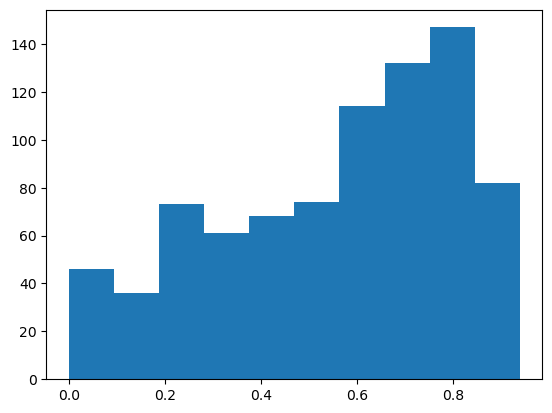

In [15]:
plt.figure()
plt.hist(y_preds)